# DGF-PT1
Notebook per la previsione di `time1` su griglia fissa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGF_PT1_train.csv")
test_df = pd.read_csv("data/input/DGF_PT1_test.csv")
all_df = pd.concat([train_df, test_df])

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time1
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,4.866905,0.277151
std,7.511607,0.260297
min,0.003257,0.000129
25%,1.282343,0.063699
50%,2.582792,0.173893
75%,4.742653,0.456343
max,65.783894,1.084001


In [3]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 8.947738636787152


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

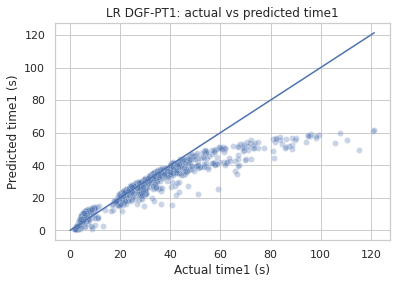

In [4]:
plt.title("LR DGF-PT1: actual vs predicted time1")
plt.plot([0, test_res_lr.time1.max()], [0, test_res_lr.time1.max()])
sns.scatterplot(data=test_res_lr, x="time1", y="prediction", alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgf-pt1/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

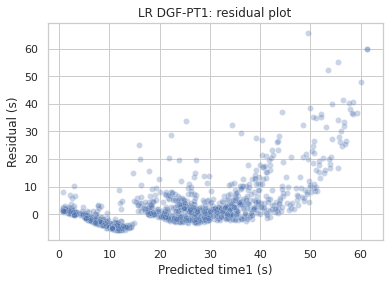

In [5]:
plt.title("LR DGF-PT1: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time1 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt1/lr-grafico-residui.pdf")
plt.show()

Si può invece notare come la distribuzione dell'errore segua circa una distribuzione normale, al contrario dell'errore relativo.

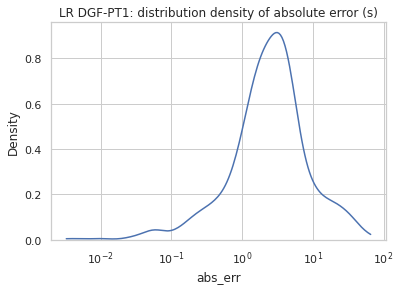

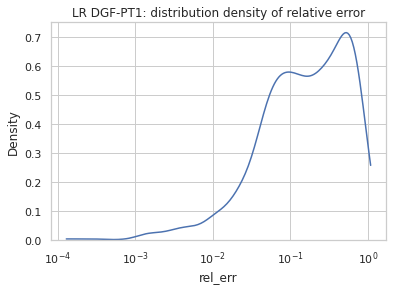

In [6]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.xscale("log")
plt.title("LR DGF-PT1: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("LR DGF-PT1: distribution density of relative error")
plt.show()

## DGF-PT1 senza HP tuning

La prima prova con un FCNN viene fatta usando due hidden layer, addestrata per 500 epoch.

In [7]:
config = {
    "batch": "full",
    "optimizer": {
        "name": "adam",
        "lr": 0.05,
        "weight_decay": 0.0
    },
    "loss": "mse",
    "model": {
        "layers": [{
            "size": 14,
            "dropout": 0.0,
        }, {
            "size": 7,
            "dropout": 0.0
        }]
    }
}
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_noopt = model.fit(data, 500)
test_res_noopt = model.test(data)

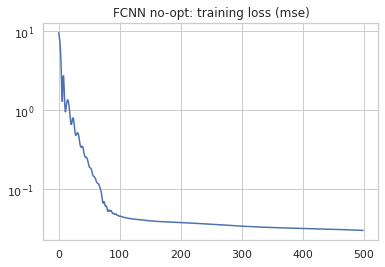

In [8]:
train_res_noopt.train_loss.plot(grid=True, logy=True)
plt.title(f"FCNN no-opt: training loss ({config['loss']})")
plt.show()

Si può notare un miglioramento rispetto al modello LR guardando il massimo e il 75° percentile dell'errore massimo e relativo.

In [9]:
test_res_noopt["abs_err"] = (test_res_noopt.target - test_res_noopt.prediction).abs()
test_res_noopt["rel_err"] = test_res_noopt.abs_err / test_res_noopt.target
test_res_noopt["residual"] = test_res_noopt.target - test_res_noopt.prediction
test_res_noopt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,2.460690,0.110880
std,3.832117,0.099308
min,0.003416,0.000120
25%,0.532149,0.045245
50%,1.222640,0.088496
75%,2.900687,0.147178
max,50.331520,0.728160


Il RMSE si è quasi dimezzato rispetto al LR.

In [10]:
print("RMSE:", np.sqrt((test_res_noopt.abs_err ** 2).mean()))

RMSE: 4.552731771838961


Lo stesso miglioramento si può apprezzare anche guardando il grafico tra tempo osservato e previsto, in cui è meno marcato il progressivo aumento dell'errore all'aumentare del tempo osservato.

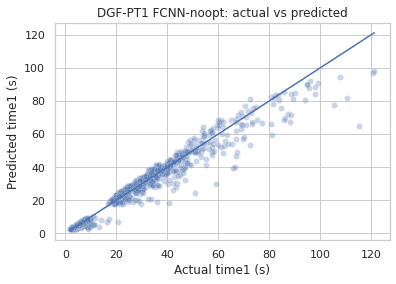

In [11]:
plt.title("DGF-PT1 FCNN-noopt: actual vs predicted")
plt.plot([test_res_noopt.target.min(), test_res_noopt.target.max()], [test_res_noopt.target.min(), test_res_noopt.target.max()])
sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.prediction, alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-noopt-correlazione-osservazione-previsione.pdf")
plt.show()

Anche il grafico dei residui rispetto al valore predetto presenta pattern meno evidenti Tuttavia, si può notare come vi sia un intervallo vuoto tra le previsioni nell'intervallo tra 10 e 20 secondi circa.

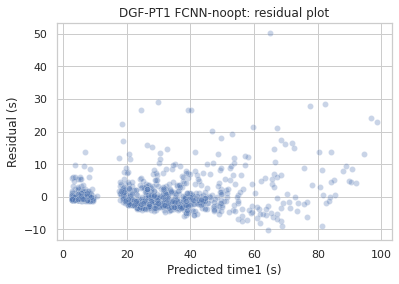

In [12]:
plt.title("DGF-PT1 FCNN-noopt: residual plot")
sns.scatterplot(data=test_res_noopt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time1 (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-noopt-grafico-residui.pdf")
plt.show()

## DGF-PT1 con HP tuning
Il modello è stato sottoposto a hyperparameter tuning, effettuando 500 tentativi con Bayesian Optimization. Come funzione obiettivo da minimizzare è stato considerato unicamente RMSE, in quanto si è interessati a minimizzare l'errore per le esecuzioni più lunghe e a non avere outlier. Per ogni tentativo, è stato effettuato il 10-fold cross validation ed è stato preso il minimo valore di RMSE del cross-validation set.

In [13]:
with open("data/hpopt/DGF_PT1.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [14]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

In [15]:
print("Best loss", best["result"]["loss"])

Best loss 2.9137998341509186


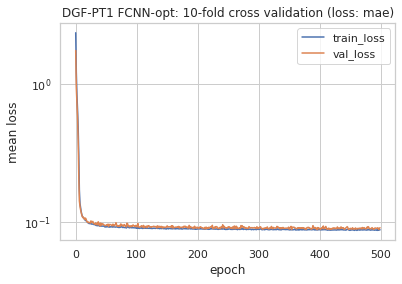

In [16]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"DGF-PT1 FCNN-opt: 10-fold cross validation (loss: {config['loss']})")
plt.ylabel("mean loss")
plt.show()

Epoch del minimo della funzione obiettivo, sarà usata successivamente per riaddestrare il modello.

In [17]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 396


Il modello ottimizzato ha due hidden layer con una dimensione leggermente maggiore rispetto al modello non ottimizzato e usa MAE come loss function.

In [18]:
print(yaml.dump(config))

batch: 128
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 19
  - dropout: 0.0
    size: 8
optimizer:
  lr: 0.003637727054425778
  name: adam
  weight_decay: 0.016597853592183014



Il modello viene riaddestrato usando tutto il training set, fino all'epoch che ha dato il miglior risultato durante l'HP tuning.

In [19]:
data = CosmoData(train_df, None, test_df, config["batch"])
model = CosmoPredictor(data.input_size, config)
train_res_opt = model.fit(data, best_epoch)
test_res_opt = model.test(data)

<AxesSubplot:>

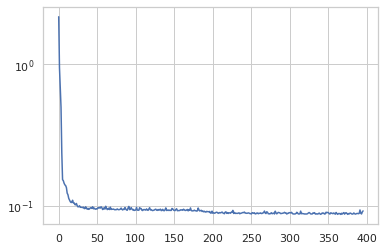

In [20]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Si nota un miglioramento sia nell'errore assoluto che relativo rispetto al modello non ottimizzato (tranne che per l'errore relativo massimo, che rimane uguale).

In [21]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1152.000000,1152.000000
mean,1.631771,0.083057
std,2.940380,0.097672
min,0.001940,0.000055
25%,0.344304,0.026042
50%,0.853345,0.052229
75%,1.780261,0.098775
max,40.740395,0.750609


Il RMSE è migliore rispetto al modello non ottimizzato e si discosta di 0.9 secondi (in più) rispetto al RMSE del cross-validation set.

In [22]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 3.361696470422944


Tuttavia, notiamo come il pattern nel confronto tra osservazione e previsione siano inalterati (seppur migliorati): c'è qualche outlier nell'estremo superiore e i task con tempo di esecuzione tra 10 e 20 secondi sono tutti sottostimati.

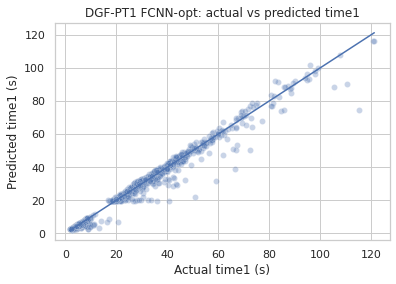

In [23]:
plt.title("DGF-PT1 FCNN-opt: actual vs predicted time1")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
sns.scatterplot(x=test_res_opt.target, y=test_res_opt.prediction, alpha=0.3)
plt.xlabel("Actual time1 (s)")
plt.ylabel("Predicted time1 (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Il miglioramento si apprezza maggiormente nel grafico dei residui.

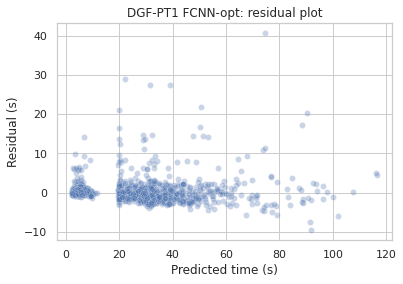

In [24]:
plt.title("DGF-PT1 FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-opt-grafico-residui.pdf")
plt.show()

Qui sotto, sono confrontati i grafici di correlazione tra errore assoluto e tempo osservato dei tre modelli. Si può notare il netto miglioramento per i task con tempo maggiore e una ulteriore minimizzazione dell'errore nel caso dell'FCNN ottimizzato nella zona centrale del tempo osservato.

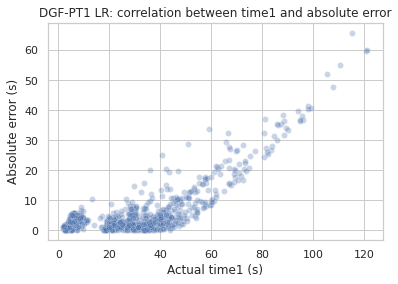

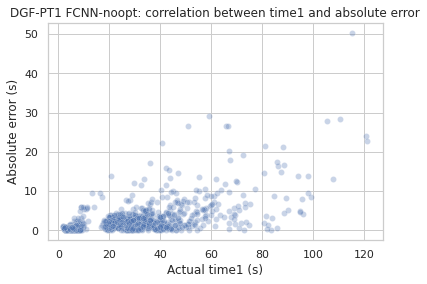

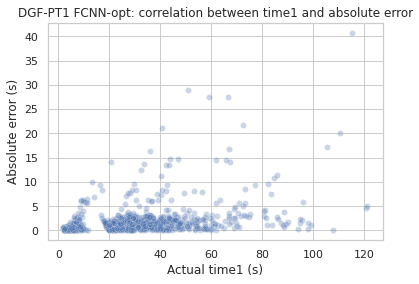

In [25]:
sns.scatterplot(x=test_res_lr.time1, y=test_res_lr.abs_err, alpha=0.3)
plt.title("DGF-PT1 LR: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt1/lr-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.abs_err, alpha=0.3)
plt.title("DGF-PT1 FCNN-noopt: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-noopt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.abs_err, alpha=0.3)
plt.title("DGF-PT1 FCNN-opt: correlation between time1 and absolute error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgf-pt1/fcnn-opt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

Qui sotto vediamo invece la correlazione con l'errore relativo: si nota come nel caso di LR l'errore sia alto nel caso di tempi brevi e poi torni a salire per i tempi più lunghi. Negli altri due casi, invece, si hanno risultati peggiori nel caso dei tempi brevi (ma significativamente migliori rispetto a LR) e non sia più presente un rapporto lineare tra errore relativo e tempo di esecuzione per i valori osservati più alti (da 40 secondi circa in poi). Nel caso ottimizzato, gli errori sono analoghi al caso non ottimizzato ma leggermente migliori e l'errore peggiore per valori osservati più piccoli era previsto, in quanto si è data maggior attenzione a minimizzare l'errore assoluto e gli outlier.

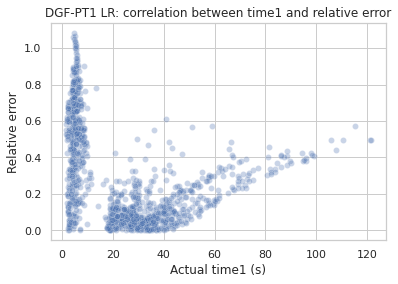

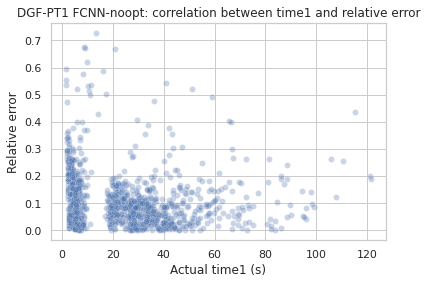

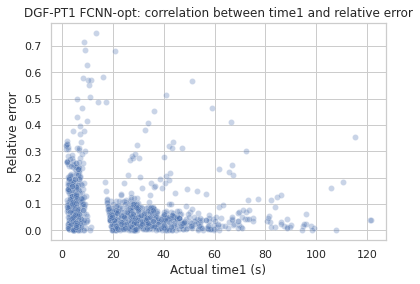

In [26]:
sns.scatterplot(x=test_res_lr.time1, y=test_res_lr.rel_err, alpha=0.3)
plt.title("DGF-PT1 LR: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt1/lr-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_noopt.target, y=test_res_noopt.rel_err, alpha=0.3)
plt.title("DGF-PT1 FCNN-noopt: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt1/fcnn-noopt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

sns.scatterplot(x=test_res_opt.target, y=test_res_opt.rel_err, alpha=0.3)
plt.title("DGF-PT1 FCNN-opt: correlation between time1 and relative error")
plt.xlabel("Actual time1 (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt1/fcnn-opt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

Di seguito, possiamo vedere le funzioni cumulative dell'errore assoluto e relativo nei tre modelli studiati. Come si poteva già dedurre dalle precedenti osservazioni, i modelli FCNN sono migliori della LR (in particolar modo per quanto riguarda l'errore relativo). Inoltre, l'FCNN ottimizzato ha una curva più ripida rispetto a quello non ottimizzato: questo comporta che un numero maggiore di previsioni ha al massimo un certo errore - e quindi gli errori peggiori riguardano una percentuale minore del test set.

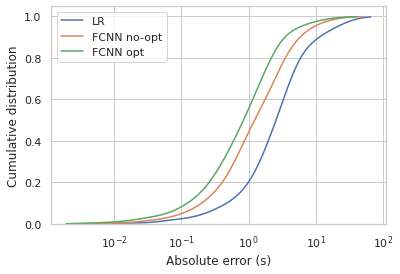

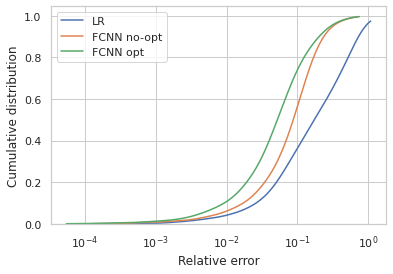

In [27]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pt1/cdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.legend()
plt.savefig("tex/images/dgf-pt1/cdf-errore-relativo.pdf")
plt.show()

Nel caso delle funzioni di distribuzione dell'errore assoluto e relativo, notiamo come solo FCNN ottimizzato abbia un andamento normale in entrambi i casi: questo significa che entrambi gli errori hanno un comportamento più simile a quello casuale - e quindi il modello riesce a spiegare abbastanza correttamente il comportamento del tempo di esecuzione.

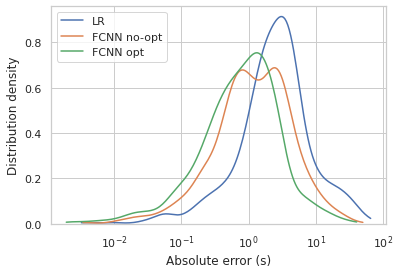

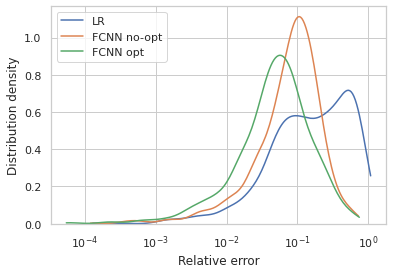

In [28]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pt1/pdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_noopt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN no-opt")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgf-pt1/pdf-errore-relativo.pdf")
plt.show()

Qui sotto, si riportano i grafici dei tre modelli che mostrano il rapporto tra osservato e previsto, in modo da poterli confrontare più facilmente.

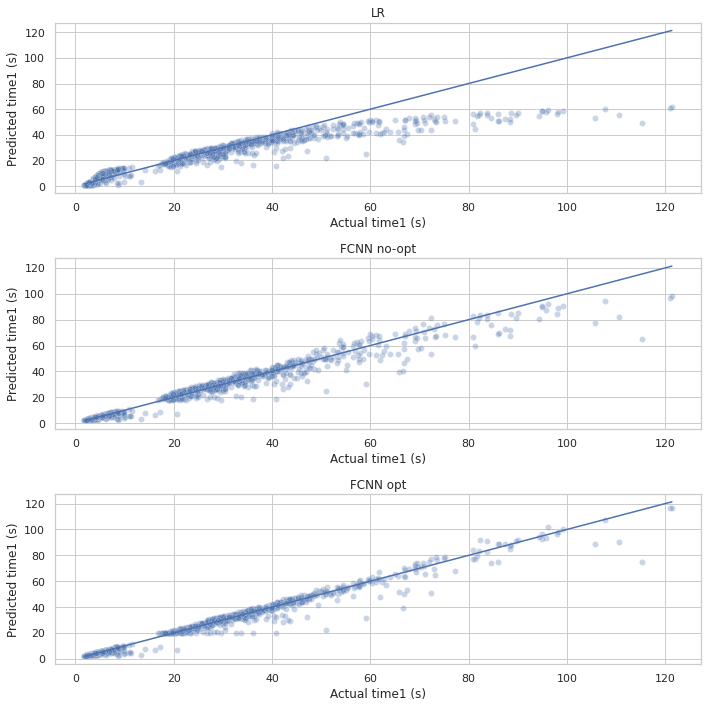

In [29]:
figure, axs = plt.subplots(3, figsize=(10, 10))

for ax, name, df in zip(axs, ("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    ax.set_title(f"{name}")
    ax.set_xlabel("Actual time1 (s)")
    ax.set_ylabel("Predicted time1 (s)")
    ax.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3, ax=ax)
    
figure.tight_layout()
plt.show()

In [30]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE LR: 4.866905197030667
MAE FCNN no-opt: 2.460690097986824
MAE FCNN opt: 1.6317707292942538


In [31]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):    
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE LR: 8.947738636787152
RMSE FCNN no-opt: 4.552731771838961
RMSE FCNN opt: 3.361696470422944


In [32]:
for name, df in zip(("LR", "FCNN no-opt", "FCNN opt"), (test_res_lr, test_res_noopt, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE LR: 27.715124194566286
MAPE FCNN no-opt: 11.087963997004865
MAPE FCNN opt: 8.305686364503135


## Conclusioni

Il modello è soddisfacente: essendo la previsione del primo step di previsione, l'errore riguarda solo al primo loop del modello e quindi non impatta particolarmente sulla previsione finale. Guardando 95, 98 e 99 percentile notiamo che gli errori assoluti superiori a ~15 secondi riguarda l'1%.

In [33]:
test_res_opt[["abs_err", "rel_err"]].quantile([0.90, 0.95, 0.98, 0.99], interpolation="higher")

,abs_err,rel_err
0.90,2.997570,0.194667
0.95,5.861824,0.274549
0.98,9.953082,0.398045
0.99,14.669712,0.516088


In [34]:
pd.concat([test_df, test_res_opt], axis=1).sort_values("abs_err").tail()

,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time1,target,prediction,abs_err,rel_err,residual
891,20,21,32,0,3.500000,72.35,72.350014,50.604675,21.745338,0.300557,21.745338
865,20,50,36,0,5.000000,59.02,59.020016,31.565769,27.454247,0.465168,27.454247
1134,20,32,36,0,1.153846,66.66,66.659996,39.120728,27.539268,0.413130,27.539268
480,20,37,36,1,1.000000,51.05,51.050003,22.014372,29.035631,0.568768,29.035631
403,20,14,32,0,1.823529,115.24,115.240005,74.499611,40.740395,0.353526,40.740395


Inoltre, dall'analisi del modello si può individuare un task che ha avuto qualche malfunzionamento durante l'esecuzione e che corrisponde all'unico errore di previsione maggiore di 30 secondi. Qui sotto possiamo notare come abbia un valore molto distante rispetto a esecuzioni del modello con parametri simili

In [35]:
outlier = test_df.iloc[test_res_opt.abs_err.idxmax()]
print("Indice dell'outlier:", outlier.name)
test_df.query((
    "grid_step == @outlier.grid_step and "
    "n_nodes >= (@outlier.n_nodes - 2) and n_nodes <= (@outlier.n_nodes + 2) and "
    "n_cores >= (@outlier.n_cores - 2) and n_cores <= (@outlier.n_cores + 2) and "
    "single_precision == @outlier.single_precision"
)).sort_values("time1")

Indice dell'outlier: 403


,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time1
406,20,14,34,0,2.500000,69.10
677,20,14,32,0,2.333333,69.47
1026,20,16,30,0,5.000000,71.06
847,20,13,32,0,1.631579,73.36
274,20,13,32,0,2.533333,75.14
797,20,14,30,0,2.928571,85.93
19,20,12,30,0,1.080000,88.49
403,20,14,32,0,1.823529,115.24
